# Normalization + ML Classification Model with/without Top Features

1. No oversampling techniques applied
2. No feature engineering applied

# 1. Import Necessary Libraries

In [1]:
# For Computational and random seed purpose
import numpy as np
np.random.seed(42)
# To read csv file
import pandas as pd
# To Split data into train and cv data
from sklearn.model_selection import train_test_split
# To compute AUROC score
# For AUROC Score (Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
from sklearn.metrics import  roc_curve, auc
# For Hyperparameter and CV Fold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
# For plot AUROC graph
import matplotlib.pyplot as plt
# Data is umbalance, we need Calibrated Model to ive confidence probabilities result
from sklearn.calibration import CalibratedClassifierCV
# For heatmap
import seaborn as sns
# To ignore warninga
import warnings
warnings.filterwarnings('ignore')
# To stndardize the data
from sklearn.preprocessing import MinMaxScaler
import tqdm

# 2. Read train data

In [2]:
# Locate parent directory
data_dir = "./"

# Read csv file and display top 5 rows
df_train = pd.read_csv(data_dir+'/train.csv')
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [3]:
df_test = pd.read_csv(data_dir+'/test.csv')
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


# 3. Take train and test values from DataFrame

In [4]:
# Take separate for features value
tr_X = df_train.drop(['id','target'], axis=1)
# Take separate for class value
tr_y = df_train['target'].values
# Take test feature value
ts_X = df_test.drop(['id'], axis=1)

Note: Don't worry about splitting train data into train and cv. I apply Stratify CV technique while modelling

# 4. Standardization

In [5]:
stand_vec = MinMaxScaler()
tr_X = stand_vec.fit_transform(tr_X)
pd.DataFrame(tr_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.454564,0.952523,0.538081,0.340156,0.708798,0.423909,0.496197,0.591415,0.098864,0.786842,...,0.647557,0.722731,0.593665,0.358949,0.718121,0.157182,0.627768,0.437245,0.630322,0.388295
1,0.695866,0.365981,0.356790,0.523392,0.391074,0.560837,0.751177,0.603498,0.525000,0.389098,...,0.465514,0.142639,0.273075,0.755630,0.449664,0.233435,0.370698,0.310441,0.337487,0.713283
2,0.367581,0.531215,0.362753,0.488694,0.465337,0.576268,0.534770,0.520191,0.550189,0.478195,...,0.496913,0.516018,0.279447,0.630581,0.858153,0.307432,0.185690,0.514624,0.595016,0.365014
3,0.488334,0.543925,0.488840,0.140741,0.387781,0.376020,0.351503,0.680127,0.619508,0.495301,...,0.423355,0.587910,0.393592,0.296326,0.759478,0.570530,0.352981,0.466864,0.397270,0.596077
4,0.954973,0.392523,0.509116,0.455750,0.693433,0.787336,0.644875,0.787440,0.521970,0.856955,...,0.653025,0.491419,0.941562,0.290399,0.413749,0.717395,0.660988,0.787486,0.539831,0.598469


In [6]:
ts_X = stand_vec.transform(ts_X)
pd.DataFrame(ts_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.576955,0.354766,0.150281,0.520078,0.338760,0.593650,0.635820,0.527027,0.394129,0.686466,...,0.479097,-0.035278,0.348079,0.897669,0.545982,0.838949,0.552470,0.494632,0.522623,0.714240
1,0.633442,0.718692,0.337877,0.722417,0.310774,0.589748,0.643607,0.497774,0.562689,0.698684,...,0.374140,0.453280,0.506463,0.606875,0.532197,0.312591,-0.085860,0.565902,0.383623,0.436772
2,0.832788,0.642991,0.412336,0.622612,0.382294,0.757893,0.411988,0.228140,0.263258,0.475188,...,0.478038,0.532799,0.391407,0.341565,0.590604,0.608254,0.614991,0.538874,0.279484,0.950885
3,0.360827,0.201121,0.305844,0.572515,0.760563,0.595424,0.281963,0.662321,0.621023,0.550376,...,0.435350,0.315789,0.548334,0.481035,0.444586,0.642915,0.859455,0.708812,0.238837,0.314304
4,0.628940,0.502056,0.621912,0.143470,0.471008,0.570238,0.680369,0.267250,0.253030,0.268985,...,0.879873,0.258009,0.541234,0.721454,0.570288,0.547155,0.437138,0.485006,0.305296,0.689683


# 5. Apply ML Models (with hyperparameter)

In [7]:
def hyperparameter_model(models, params):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value fr tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    # Random shuffle after every iteration with stratify
    str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    # Find the right hyperparameter for the model
    grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True, scoring='roc_auc')
    # Fit on train data
    grid_clf.fit(tr_X, tr_y)
    return grid_clf

def plot_feature_importance(model, model_name, top_n = 10):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    try_true: train true label
    try_pred: train predict probabilities value
    cvy_true: cv true label
    cvy_pred: cv predict probabilities value
    n_classes: number of unique classes
    
    Return:
    Plot of ROC Curve for train and cv data    
    '''       
    column_name = df_train.drop(['id','target'], axis=1).columns
    if model_name == 'log_model':
        feat_imp_coef = model.coef_.ravel()
    else:
        feat_imp_coef = model.feature_importances_
    temp = pd.DataFrame(data=np.column_stack((column_name, feat_imp_coef)), columns=['col_name','coef'])
    temp = temp.sort_values(by='coef', ascending=False).reset_index()
    df = temp
    temp = temp[:top_n]
    plt.figure(figsize=(20,5))
    sns.barplot(data=temp, y='coef', x='col_name', order=temp['col_name'])
    plt.grid()
    plt.show()
    return df

In [8]:
def forward_selection_model(model, top_n=10):
    top_column = []
    exist_score = 0
    for n in range(top_n):
        print('for {} feature'.format(n+1))
        flag = 0
        for i in tqdm.tqdm_notebook(range(tr_X.shape[1])):
            # Finding for first top feature
            if len(top_column) == 0:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,tr_X[:,[i]],tr_y,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
            # Excluded apart from top column
            elif i not in top_column:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,tr_X[:,np.concatenate((top_column,[i]))],tr_y,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
        
        if flag == 1:
            print('Current top feature {} and score: {}'.format(top_current,exist_score))
            print('Appended to top column')
            top_column.append(top_current)
            print(top_column)
        else:
            break
    return top_column

# 5.1 kNN

In [9]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree', 'brute']}
# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)

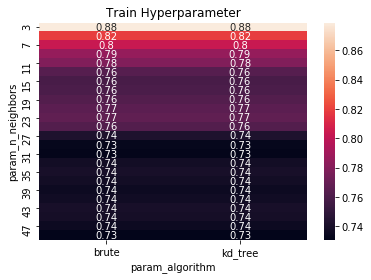

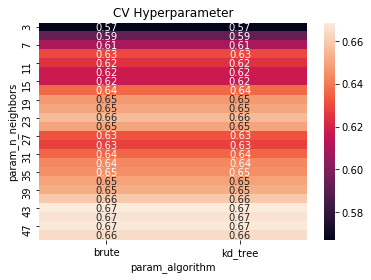

In [11]:
cv_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_test_score', index='param_n_neighbors', \
                     columns='param_algorithm')
tr_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_train_score', index='param_n_neighbors', \
                     columns='param_algorithm')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [12]:
print(knn_clf.best_params_)

{'algorithm': 'kd_tree', 'n_neighbors': 43}


In [13]:
clf = CalibratedClassifierCV(knn_clf, cv=3)
clf.fit(tr_X,tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=KNeighborsClassifier(algorithm='auto',
                                                                                  leaf_size=30,
                                                                                  metric='minkowski',
                                                                                  metric_params=None,
                                                                                  n_jobs=None,
                                                                                  n_neighbors=5,
                                                                                  p=2,
                                                                                  weights='uniform'),
                             

# 5.1.1 Kaggle Score without top features

In [14]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
knn_csv = clf.predict_proba(ts_X)[:,1]
knn_df = pd.DataFrame(np.column_stack((temp_id,knn_csv)), columns=['id','target'])
knn_df['id'] = knn_df['id'].astype('int32')
knn_df.to_csv(data_dir+'/submission_knn.csv', index=False)

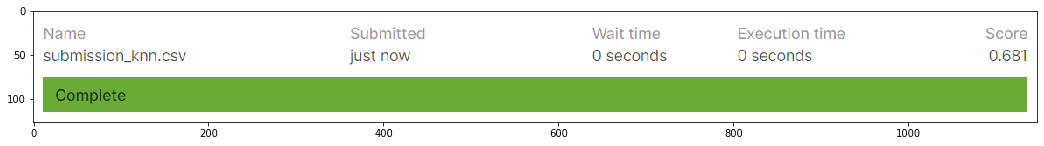

In [15]:
image = plt.imread(data_dir+'/submission_knn.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 5.2 Logistic Regression

In [16]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

In [17]:
# LogisticRegression (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# List of hyperparameter that has to be tuned
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
# Instance of Logsitic Regression
log_model = LogisticRegression(random_state=42, class_weight='balanced')
# Call hyperparameter to get the best parameters of this model
log_clf = hyperparameter_model(log_model, params)

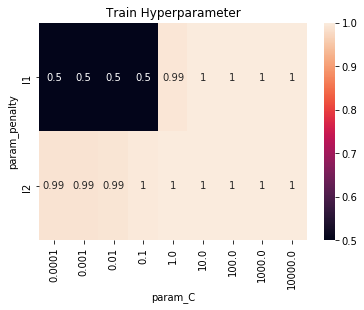

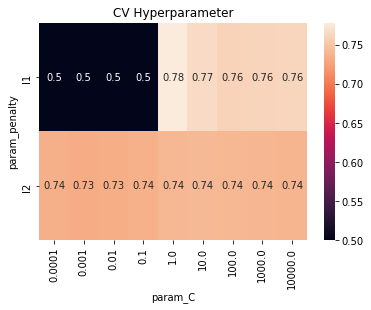

In [18]:
cv_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_test_score', index='param_penalty', \
                     columns='param_C')
tr_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_train_score', index='param_penalty', \
                     columns='param_C')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [19]:
print(log_clf.best_params_)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [20]:
log_model = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model.fit(tr_X, tr_y)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

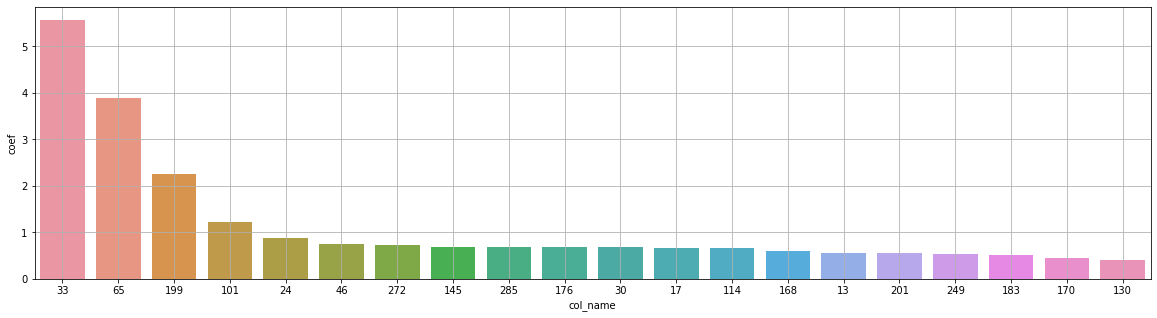

In [21]:
df = plot_feature_importance(log_model, 'log_model', 20)

In [22]:
clf = CalibratedClassifierCV(log_clf, cv=3)
clf.fit(tr_X,tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=LogisticRegression(C=1.0,
                                                                                class_weight='balanced',
                                                                                dual=False,
                                                                                fit_intercept=True,
                                                                                intercept_scaling=1,
                                                                                l1_ratio=None,
                                                                                max_iter=100,
                                                                                multi_class='auto',
                                    

# 5.2.1 Kaggle Score without top features

In [23]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
log_csv = clf.predict_proba(ts_X)[:,1]
log_df = pd.DataFrame(np.column_stack((temp_id,log_csv)), columns=['id','target'])
log_df['id'] = log_df['id'].astype('int32')
log_df.to_csv(data_dir+'/submission_log.csv', index=False)

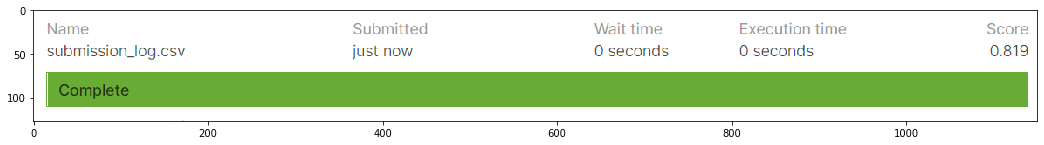

In [24]:
image = plt.imread(data_dir+'/submission_log.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.2.2 Kaggle Score Using top 10 features based on Logistic Regression Model

In [25]:
top_column = forward_selection_model(log_model)

for 1 feature



Current top feature 33 and score: 0.7347222222222222
Appended to top column
[33]
for 2 feature



Current top feature 65 and score: 0.7876388888888887
Appended to top column
[33, 65]
for 3 feature



Current top feature 217 and score: 0.8027777777777777
Appended to top column
[33, 65, 217]
for 4 feature



Current top feature 91 and score: 0.8190277777777777
Appended to top column
[33, 65, 217, 91]
for 5 feature



Current top feature 117 and score: 0.8458333333333334
Appended to top column
[33, 65, 217, 91, 117]
for 6 feature



Current top feature 194 and score: 0.852638888888889
Appended to top column
[33, 65, 217, 91, 117, 194]
for 7 feature



Current top feature 199 and score: 0.8573611111111111
Appended to top column
[33, 65, 217, 91, 117, 194, 199]
for 8 feature



Current top feature 80 and score: 0.8698611111111112
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80]
for 9 feature



Current top feature 127 and score: 0.875
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127]
for 10 feature



Current top feature 226 and score: 0.8791666666666669
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226]


In [26]:
# Store the top column name into set
log_top10_feat = set(top_column)
# Fit Logistic Regression on top features only
log_model_top = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_top.fit(tr_X[:,top_column],tr_y)
# Calibrate it in top features only
clf = CalibratedClassifierCV(log_model_top, cv=3)
clf.fit(tr_X[:,top_column],tr_y)
# Predict the probabilities of 1
ts_pred = clf.predict_proba(ts_X[:,top_column])[:,1]

In [27]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
df_tspred = pd.DataFrame(np.column_stack((temp_id,ts_pred)), columns=['id','target'])
df_tspred['id'] = df_tspred['id'].astype('int32')
df_tspred.to_csv(data_dir+'/submission_log_top10.csv', index=False)

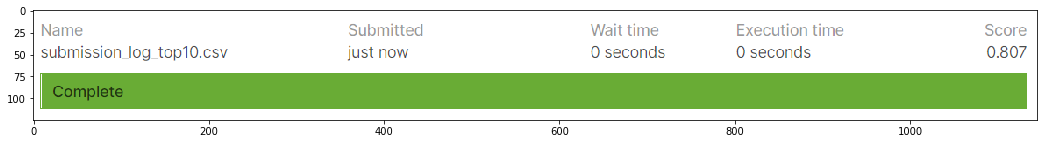

In [28]:
image = plt.imread(data_dir+'/log_csv_top10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.2.3 Kaggle Score Using top 20 features based on Logistic Regression Model

In [29]:
top_column = forward_selection_model(log_model,20)

for 1 feature



Current top feature 33 and score: 0.7347222222222222
Appended to top column
[33]
for 2 feature



Current top feature 65 and score: 0.7876388888888887
Appended to top column
[33, 65]
for 3 feature



Current top feature 217 and score: 0.8027777777777777
Appended to top column
[33, 65, 217]
for 4 feature



Current top feature 91 and score: 0.8190277777777777
Appended to top column
[33, 65, 217, 91]
for 5 feature



Current top feature 117 and score: 0.8458333333333334
Appended to top column
[33, 65, 217, 91, 117]
for 6 feature



Current top feature 194 and score: 0.852638888888889
Appended to top column
[33, 65, 217, 91, 117, 194]
for 7 feature



Current top feature 199 and score: 0.8573611111111111
Appended to top column
[33, 65, 217, 91, 117, 194, 199]
for 8 feature



Current top feature 80 and score: 0.8698611111111112
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80]
for 9 feature



Current top feature 127 and score: 0.875
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127]
for 10 feature



Current top feature 226 and score: 0.8791666666666669
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226]
for 11 feature



Current top feature 43 and score: 0.8875
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43]
for 12 feature



Current top feature 170 and score: 0.8933333333333333
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170]
for 13 feature



Current top feature 82 and score: 0.8973611111111112
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82]
for 14 feature



Current top feature 183 and score: 0.9002777777777777
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183]
for 15 feature



Current top feature 168 and score: 0.9018055555555555
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168]
for 16 feature



Current top feature 108 and score: 0.9033333333333333
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168, 108]
for 17 feature



Current top feature 114 and score: 0.9054166666666665
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168, 108, 114]
for 18 feature



Current top feature 63 and score: 0.90875
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168, 108, 114, 63]
for 19 feature



Current top feature 101 and score: 0.9105555555555557
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168, 108, 114, 63, 101]
for 20 feature



Current top feature 198 and score: 0.9113888888888888
Appended to top column
[33, 65, 217, 91, 117, 194, 199, 80, 127, 226, 43, 170, 82, 183, 168, 108, 114, 63, 101, 198]


In [30]:
# Store the top column name into set
log_top20_feat = set(top_column)
# Fit Logistic Regression on top features only
log_model_top = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_top.fit(tr_X[:,top_column],tr_y)
# Calibrate it in top features only
clf = CalibratedClassifierCV(log_model_top, cv=3)
clf.fit(tr_X[:,top_column],tr_y)
# Predict the probabilities of 1
ts_pred = clf.predict_proba(ts_X[:,top_column])[:,1]

In [31]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
df_tspred = pd.DataFrame(np.column_stack((temp_id,ts_pred)), columns=['id','target'])
df_tspred['id'] = df_tspred['id'].astype('int32')
df_tspred.to_csv(data_dir+'/submission_log_top20.csv', index=False)

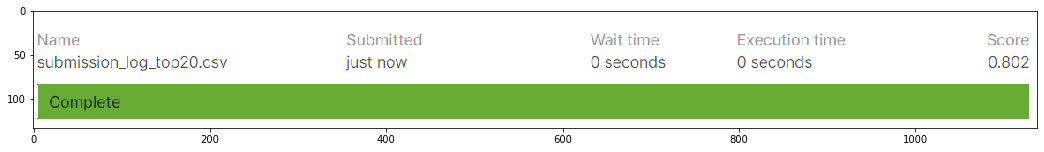

In [32]:
image = plt.imread(data_dir+'/log_csv_top20.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.3 SVC

In [33]:
# Import SVC
from sklearn.svm import SVC

In [34]:
# SVC (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

# List of hyperparameter that has to be tuned
params = {'C':[10**i for i in range(-4,5)], 'kernel':['linear','poly','sigmoid','rbf']}
# Instance of SVC
svc_model = SVC(class_weight='balanced', random_state=42, probability=True)
# Call hyperparameter to find the best parameters
svc_clf = hyperparameter_model(svc_model, params)

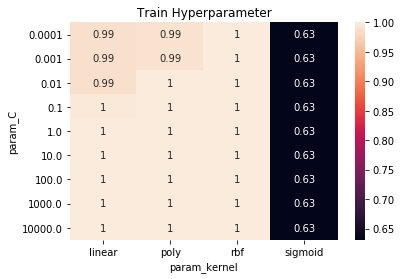

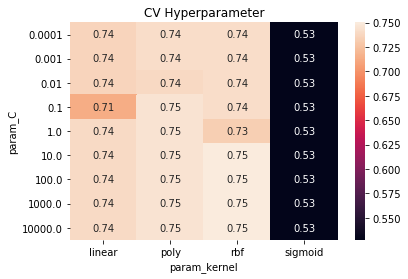

In [35]:
cv_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_test_score', index='param_C', \
                     columns='param_kernel')
tr_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_train_score', index='param_C', \
                     columns='param_kernel')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [36]:
print(svc_clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [37]:
svc_model = SVC(**svc_clf.best_params_, class_weight='balanced', random_state=42, probability=True)
svc_model.fit(tr_X, tr_y)

clf = CalibratedClassifierCV(svc_clf, cv=3)
clf.fit(tr_X,tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=SVC(C=1.0,
                                                                 break_ties=False,
                                                                 cache_size=200,
                                                                 class_weight='balanced',
                                                                 coef0=0.0,
                                                                 decision_function_shape='ovr',
                                                                 degree=3,
                                                                 gamma='scale',
                                                                 kernel='rbf',
                                                                 max_iter=-1,


# 5.3.1 Kaggle Score without top features

In [38]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
svc_csv = clf.predict_proba(ts_X)[:,1]
svc_df = pd.DataFrame(np.column_stack((temp_id,svc_csv)), columns=['id','target'])
svc_df['id'] = svc_df['id'].astype('int32')
svc_df.to_csv(data_dir+'/submission_svc.csv', index=False)

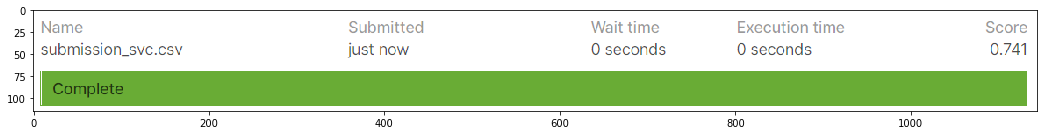

In [39]:
image = plt.imread(data_dir+'/submission_svc.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.3.2 Kaggle Score Using top 10 features based on SVC Model

In [40]:
top_column = forward_selection_model(svc_model)

for 1 feature



Current top feature 33 and score: 0.708888888888889
Appended to top column
[33]
for 2 feature



Current top feature 167 and score: 0.7570833333333334
Appended to top column
[33, 167]
for 3 feature



Current top feature 116 and score: 0.7616666666666666
Appended to top column
[33, 167, 116]
for 4 feature



Current top feature 70 and score: 0.7881944444444444
Appended to top column
[33, 167, 116, 70]
for 5 feature



Current top feature 293 and score: 0.8234722222222223
Appended to top column
[33, 167, 116, 70, 293]
for 6 feature



Current top feature 43 and score: 0.8543055555555558
Appended to top column
[33, 167, 116, 70, 293, 43]
for 7 feature



Current top feature 157 and score: 0.8663888888888889
Appended to top column
[33, 167, 116, 70, 293, 43, 157]
for 8 feature



Current top feature 103 and score: 0.8681944444444444
Appended to top column
[33, 167, 116, 70, 293, 43, 157, 103]
for 9 feature


In [41]:
# Store the top column name into set
svc_top10_feat = set(top_column)
# Fit SVC on top features only
svc_model_top = SVC(**svc_clf.best_params_, class_weight='balanced', random_state=42, probability=True)
svc_model_top.fit(tr_X[:,top_column],tr_y)
# Calibrate it in top features only
clf = CalibratedClassifierCV(svc_model_top, cv=3)
clf.fit(tr_X[:,top_column],tr_y)
# Predict the probabilities of 1
ts_pred = clf.predict_proba(ts_X[:,top_column])[:,1]

In [42]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
df_tspred = pd.DataFrame(np.column_stack((temp_id,ts_pred)), columns=['id','target'])
df_tspred['id'] = df_tspred['id'].astype('int32')
df_tspred.to_csv(data_dir+'/submission_svc_top10.csv', index=False)

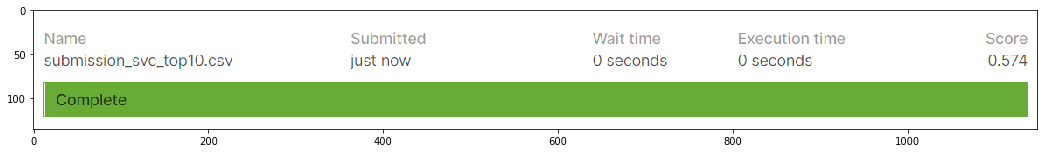

In [43]:
image = plt.imread(data_dir+'/svc_csv_top10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.4 RandomForest

In [44]:
# Impoer Random Forest
from sklearn.ensemble import RandomForestClassifier

In [45]:
# RandomForest (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

# List of hyperparameter that has t be tuned
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
# Instance of randomforest
rf_model = RandomForestClassifier(random_state=42)
# Perform GridSearchCV to find best parameters
rf_clf = hyperparameter_model(rf_model, params)

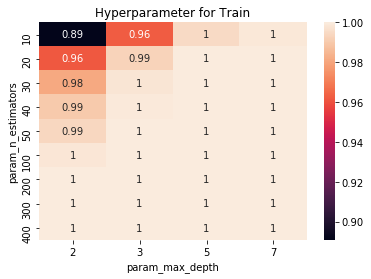

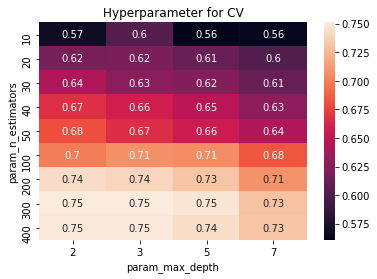

In [46]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [47]:
print(rf_clf.best_params_)

{'max_depth': 2, 'n_estimators': 300}


In [48]:
# Instance of randomforest with best parameters
rf_model = RandomForestClassifier(**rf_clf.best_params_, random_state=42)
# Fit the model
rf_model.fit(tr_X,tr_y)
# Calibrate the model
clf = CalibratedClassifierCV(rf_clf, cv=3)
clf.fit(tr_X, tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight=None,
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=

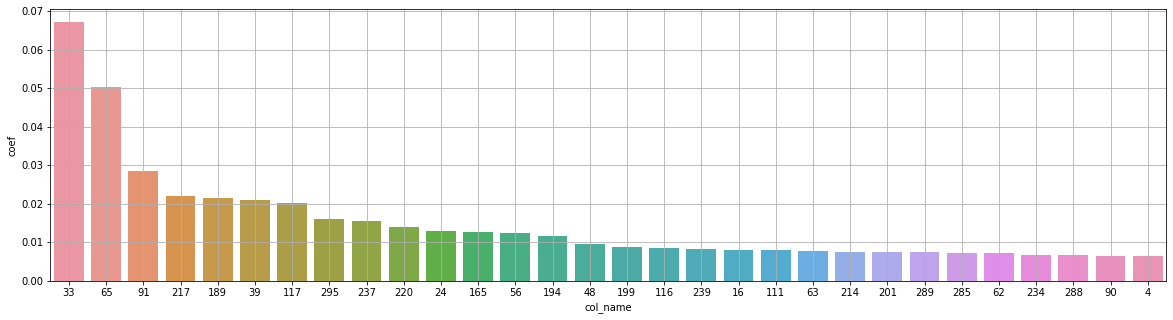

In [49]:
# Plot the feature importance based on this model
df = plot_feature_importance(rf_model, 'rf',30)

# 5.4.1 Kaggle Score without top features

In [50]:
# Create a submission file format to submit in kaggle
temp_id = df_test['id']
rf_csv = clf.predict_proba(ts_X)[:,1]
rf_df = pd.DataFrame(np.column_stack((temp_id,rf_csv)), columns=['id','target'])
rf_df['id'] = rf_df['id'].astype('int32')
rf_df.to_csv(data_dir+'/submission_rf.csv', index=False)

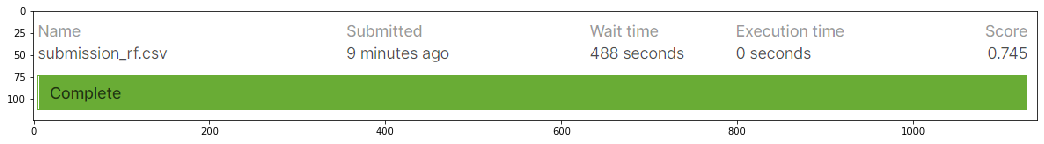

In [51]:
image = plt.imread(data_dir+'/submission_rf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.4.2 Kaggle Score Using top 10 features based on RandomForest Model

In [52]:
top_column = forward_selection_model(rf_model)

for 1 feature



Current top feature 33 and score: 0.71
Appended to top column
[33]
for 2 feature



Current top feature 65 and score: 0.7651388888888888
Appended to top column
[33, 65]
for 3 feature



Current top feature 91 and score: 0.7865277777777777
Appended to top column
[33, 65, 91]
for 4 feature



Current top feature 199 and score: 0.7890277777777779
Appended to top column
[33, 65, 91, 199]
for 5 feature



Current top feature 217 and score: 0.8052777777777779
Appended to top column
[33, 65, 91, 199, 217]
for 6 feature



Current top feature 214 and score: 0.8094444444444444
Appended to top column
[33, 65, 91, 199, 217, 214]
for 7 feature



Current top feature 189 and score: 0.8162500000000001
Appended to top column
[33, 65, 91, 199, 217, 214, 189]
for 8 feature



Current top feature 132 and score: 0.8291666666666667
Appended to top column
[33, 65, 91, 199, 217, 214, 189, 132]
for 9 feature


In [53]:
# Store the top column name into set
rf_top10_feat = set(top_column)

In [54]:
# Fit RF on top features only
rf_model_top = RandomForestClassifier(**rf_clf.best_params_, random_state=42)
rf_model_top.fit(tr_X[:,top_column],tr_y)
# Calibrate it in top features only
clf = CalibratedClassifierCV(rf_model_top, cv=3)
clf.fit(tr_X[:,top_column],tr_y)
# Predict the probabilities of 1
ts_pred = clf.predict_proba(ts_X[:,top_column])[:,1]

In [55]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
df_tspred = pd.DataFrame(np.column_stack((temp_id,ts_pred)), columns=['id','target'])
df_tspred['id'] = df_tspred['id'].astype('int32')
df_tspred.to_csv(data_dir+'/submission_rf_top10.csv', index=False)

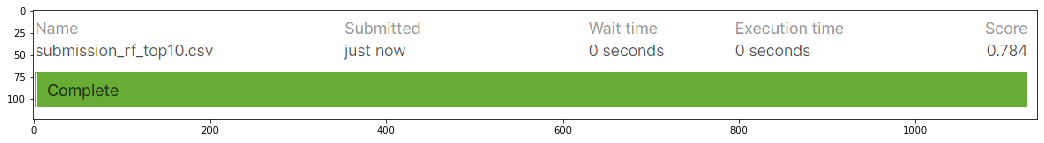

In [56]:
image = plt.imread(data_dir+'/rf_csv_top10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.5 XGBoost

In [57]:
# Import Xgboost
from xgboost import XGBClassifier

In [58]:
# Xgboost (See Docs: https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# List of hyperparameter that has to be tuned
params = {'max_depth':[2,3,5,7], 'n_estimators':[10,20,50,100,200,300,400]}
# Instance of XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=0.5)
# Call hyperparameter to find the best parameters
xgb_clf = hyperparameter_model(xgb_model, params)

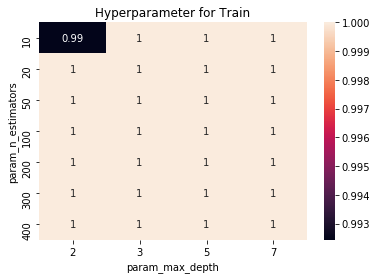

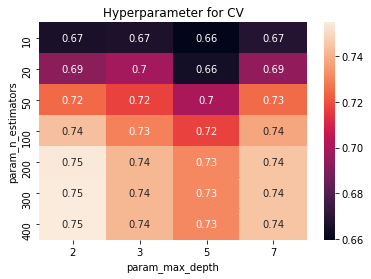

In [59]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [60]:
print(xgb_clf.best_params_)

{'max_depth': 2, 'n_estimators': 300}


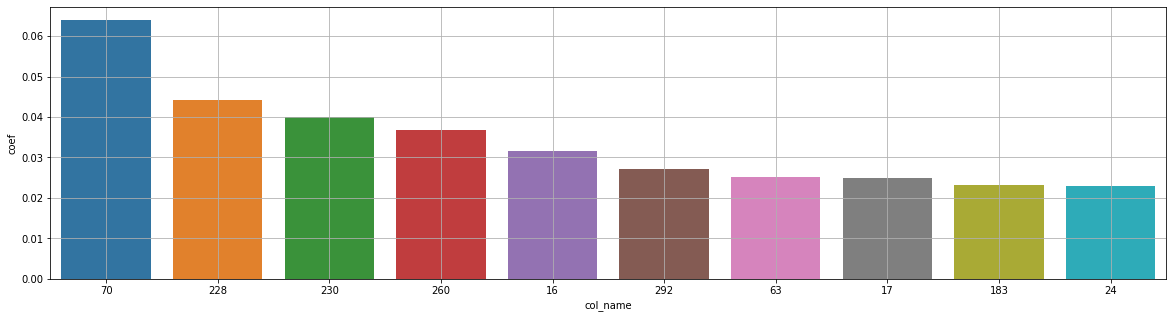

In [61]:
# Instance of randomforest with best parameters
xgb_model = XGBClassifier(**xgb_clf.best_params_, random_state=42, scale_pos_weight=0.5)
# Fit the model
xgb_model.fit(tr_X,tr_y)

# Instance of XGBoost model with best parameters
df = plot_feature_importance(xgb_model, 'xgb',10)

In [62]:
# Calibrate the model
clf = CalibratedClassifierCV(xgb_clf, cv=3)
clf.fit(tr_X, tr_y)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=None,
                                                                           gamma=None,
                                                                           gpu_id=None,
                                                                           importance_type='gain',
                                                            

# 5.5.1 Kaggle Score without top features

In [63]:
# Create submission file format to submit in Kaggle
temp_id = df_test['id']
xgb_csv = clf.predict_proba(ts_X)[:,1]
xgb_df = pd.DataFrame(np.column_stack((temp_id,xgb_csv)), columns=['id','target'])
xgb_df['id'] = xgb_df['id'].astype('int32')
xgb_df.to_csv(data_dir+'/submission_xgb.csv', index=False)

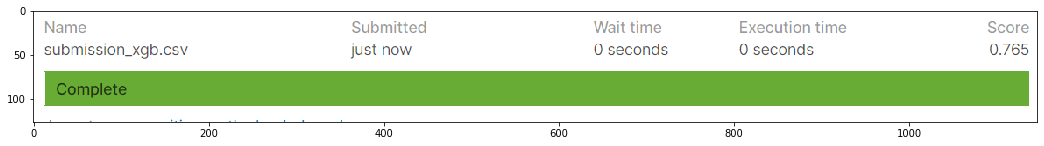

In [64]:
image = plt.imread(data_dir+'/submission_xgb.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.5.2 Using top 10 features of this model

In [65]:
top_column = forward_selection_model(xgb_model)

for 1 feature



Current top feature 91 and score: 0.6425
Appended to top column
[91]
for 2 feature



Current top feature 120 and score: 0.7105555555555556
Appended to top column
[91, 120]
for 3 feature



Current top feature 33 and score: 0.7479166666666666
Appended to top column
[91, 120, 33]
for 4 feature



Current top feature 108 and score: 0.7793055555555555
Appended to top column
[91, 120, 33, 108]
for 5 feature



Current top feature 141 and score: 0.8012500000000001
Appended to top column
[91, 120, 33, 108, 141]
for 6 feature



Current top feature 246 and score: 0.83
Appended to top column
[91, 120, 33, 108, 141, 246]
for 7 feature



Current top feature 146 and score: 0.8494444444444446
Appended to top column
[91, 120, 33, 108, 141, 246, 146]
for 8 feature



Current top feature 95 and score: 0.8691666666666668
Appended to top column
[91, 120, 33, 108, 141, 246, 146, 95]
for 9 feature



Current top feature 230 and score: 0.8737500000000001
Appended to top column
[91, 120, 33, 108, 141, 246, 146, 95, 230]
for 10 feature


In [66]:
# Store the top column name into set
xgb_top10_feat = set(top_column)

In [67]:
# Fit RF on top features only
xgb_model_top = XGBClassifier(**xgb_clf.best_params_, random_state=42, scale_pos_weight=0.5)
xgb_model_top.fit(tr_X[:,top_column],tr_y)
# Calibrate it in top features only
clf = CalibratedClassifierCV(xgb_model_top, cv=3)
clf.fit(tr_X[:,top_column],tr_y)
# Predict the probabilities of 1
ts_pred = clf.predict_proba(ts_X[:,top_column])[:,1]

In [68]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
df_tspred = pd.DataFrame(np.column_stack((temp_id,ts_pred)), columns=['id','target'])
df_tspred['id'] = df_tspred['id'].astype('int32')
df_tspred.to_csv(data_dir+'/submission_xgb_top10.csv', index=False)

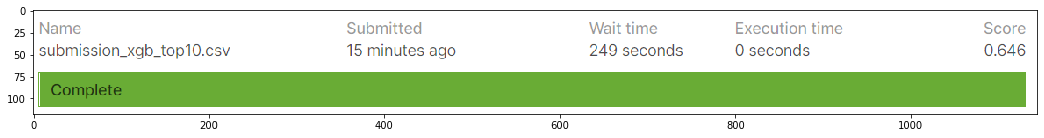

In [69]:
image = plt.imread(data_dir+'/xgb_csv_top10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.6 Stacking Classifier

In [70]:
# Combined all top features of all models
# Ref: https://www.geeksforgeeks.org/union-function-python/
comb_top_feat = list(log_top20_feat.union(svc_top10_feat, rf_top10_feat, xgb_top10_feat))

In [71]:
# Import Stacking Classifier
from mlxtend.classifier import StackingClassifier

In [72]:
# StackClassifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#methods)

# Classifier 1: Logistic Regression with best params
clf1 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', class_weight='balanced', random_state=42)
clf1.fit(tr_X,tr_y)
clf1 = CalibratedClassifierCV(clf1, cv=3)

# Classifier 2: SVC with best params
clf2 = SVC(C=10, kernel='rbf', random_state=42, class_weight='balanced', probability=True)
clf2.fit(tr_X,tr_y)
clf2 = CalibratedClassifierCV(clf2, cv=3)

# Classifier 3: XGBoost with best params
clf3 = XGBClassifier(max_depth=2, n_estimators=300, scale_pos_weight=0.5)
clf3.fit(tr_X,tr_y)
clf3 = CalibratedClassifierCV(clf3, cv=3)

# Classifier 4: RF with best params
clf4 = RandomForestClassifier(max_depth=2, n_estimators=300)
clf4.fit(tr_X,tr_y)
clf4 = CalibratedClassifierCV(clf4, cv=3)

# Stack Classifier
sclf = StackingClassifier(classifiers=[clf1,clf2,clf3,clf4], meta_classifier=clf1, use_probas=True)

# Fit the model
sclf.fit(tr_X, tr_y)

StackingClassifier(average_probas=False,
                   classifiers=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                         class_weight='balanced',
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=None,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',
                                                                                         n_jobs=None,
             

# 5.6.1 Kaggle score without top features

In [73]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
sclf_csv = sclf.predict_proba(ts_X)[:,1]
sclf_df = pd.DataFrame(np.column_stack((temp_id,sclf_csv)), columns=['id','target'])
sclf_df['id'] = sclf_df['id'].astype('int32')
sclf_df.to_csv(data_dir+'/submission_sclf.csv', index=False)

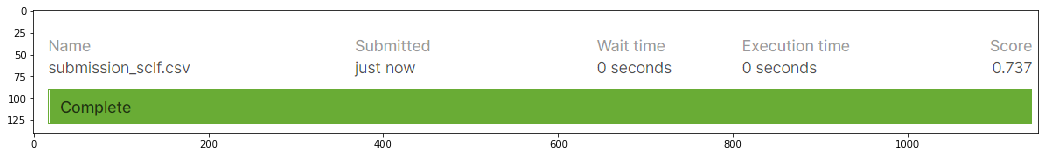

In [74]:
image = plt.imread(data_dir+'/submission_sclf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.6.2 Using Top features

In [75]:
# Fit the model
sclf.fit(tr_X[:,comb_top_feat], tr_y)

StackingClassifier(average_probas=False,
                   classifiers=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                         class_weight='balanced',
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=None,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',
                                                                                         n_jobs=None,
             

In [76]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
sclf_csv = sclf.predict_proba(ts_X[:, comb_top_feat])[:,1]
sclf_df = pd.DataFrame(np.column_stack((temp_id,sclf_csv)), columns=['id','target'])
sclf_df['id'] = sclf_df['id'].astype('int32')
sclf_df.to_csv(data_dir+'/submission_sclf_topfeat.csv', index=False)

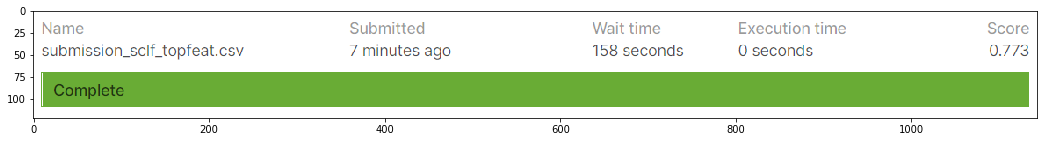

In [78]:
image = plt.imread(data_dir+'/sclf_topfeat.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.7 Voting Classifier (Without Stack Classifier + no weights)

In [79]:
# Import Voting Classifier
from mlxtend.classifier import EnsembleVoteClassifier

In [80]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

# 5.7.1 Kaggle Score without top features

In [81]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf.csv', index=False)

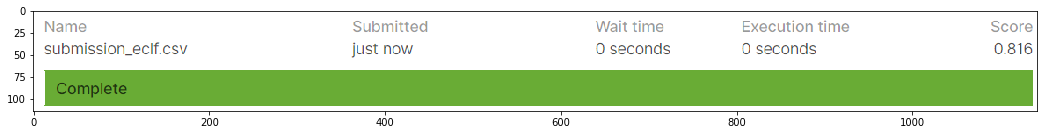

In [82]:
image = plt.imread(data_dir+'/submission_eclf.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.7.2 Kaggle Score using top features

In [83]:
# Fit the model
eclf.fit(tr_X[:,comb_top_feat], tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

In [84]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X[:,comb_top_feat])[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_topfeat.csv', index=False)

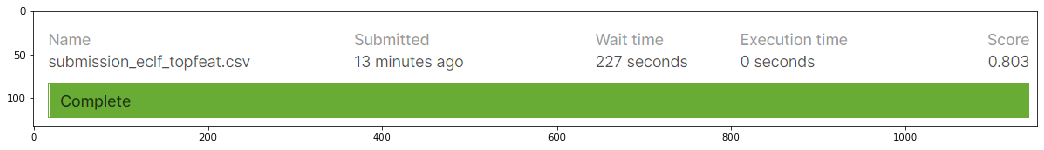

In [85]:
image = plt.imread(data_dir+'/eclf_topfeat.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.8 Voting Classifier (With Stack Classifier + no weights)

In [86]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4,sclf])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

# 5.8.1 Kaggle Score without top features

In [87]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack.csv', index=False)

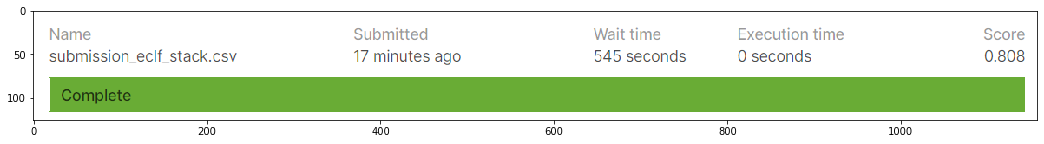

In [88]:
image = plt.imread(data_dir+'/submission_eclf_stack.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.8.2 Kaggle Score using top features

In [89]:
# Fit the model
eclf.fit(tr_X[:,comb_top_feat], tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

In [90]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X[:,comb_top_feat])[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_topfeat.csv', index=False)

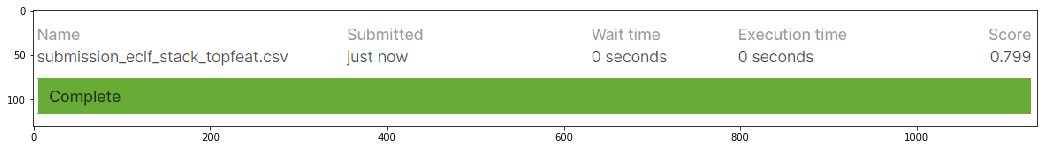

In [92]:
image = plt.imread(data_dir+'/submission_eclf_stack_topfeat.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.9 Voting Classifier (without Stack Classifier + weights)

In [93]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4], weights=[0.4,0.2,0.2,0.2])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

 # 5.9.1 Kaggle Score without top features

In [94]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_weights.csv', index=False)

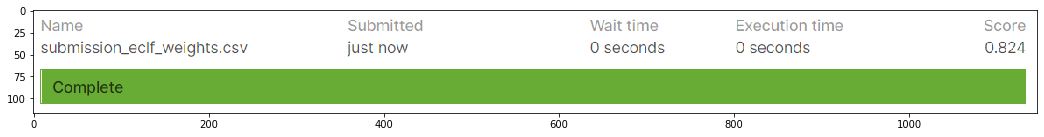

In [95]:
image = plt.imread(data_dir+'/submission_eclf_weights.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.9.2 Kaggle Score using top features

In [96]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4], weights=[0.4,0.2,0.2,0.2])
# Fit the train data
eclf.fit(tr_X[:,comb_top_feat],tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

In [97]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X[:,comb_top_feat])[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_weights_topfeat.csv', index=False)

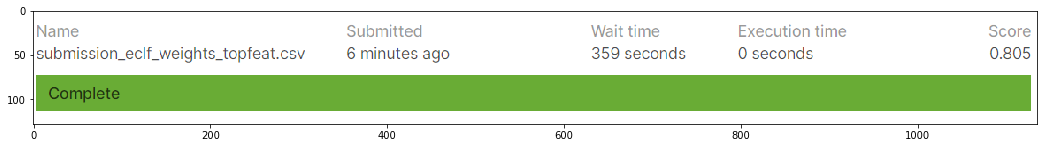

In [98]:
image = plt.imread(data_dir+'/submission_eclf_weights_topfeat.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.10 Voting Classifier (with Stack Classifier + weights)

In [99]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4,sclf], weights=[0.4,0.1,0.1,0.2,0.2])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

# 5.10.1 Kaggle Score without top features

In [100]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_weights.csv', index=False)

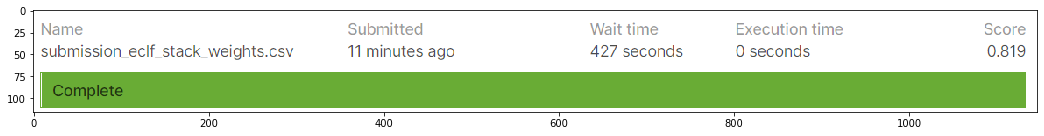

In [101]:
image = plt.imread(data_dir+'/submission_eclf_stack_weights.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 5.10.2 Kaggle Score using top features

In [102]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4,sclf], weights=[0.4,0.1,0.1,0.2,0.2])
# Fit the train data
eclf.fit(tr_X[:,comb_top_feat],tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                                 

In [103]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X[:,comb_top_feat])[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_weights_topfeat.csv', index=False)

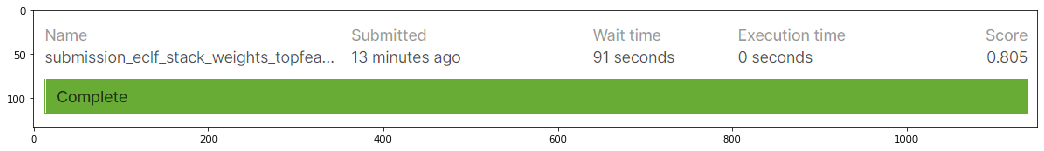

In [104]:
image = plt.imread(data_dir+'/submission_eclf_stack_weights_topfeat.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 6. Summary of All Models

In [107]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Features','Hyperparameter','Test Score']
x.add_row(['knn','AF',r"{'algorithm': 'kd_tree', 'n_neighbors': 43}",0.681])
x.add_row(['Logistic Regression','AF',r"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.819])
x.add_row(['Logistic Regression','top10',r"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.807])
x.add_row(['Logistic Regression','top20',r"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.802])
x.add_row(['SVC','AF',r"{'C': 10, 'kernel': 'rbf'}",0.741])
x.add_row(['SVC','top10',r"{'C': 10, 'kernel': 'rbf'}",0.574])
x.add_row(['RandomForest','AF',r"{'max_depth': 2, 'n_estimators': 300}",0.745])
x.add_row(['RandomForest','top10',r"{'max_depth': 2, 'n_estimators': 300}",0.784])
x.add_row(['XGBoost','AF',r"{'max_depth': 2, 'n_estimators': 300}",0.765])
x.add_row(['XGBoost','top10',r"{'max_depth': 2, 'n_estimators': 300}",0.646])
x.add_row(['Stacking Classifier','AF','-',0.737])
x.add_row(['Stacking Classifier','topfeatures','-',0.773])
x.add_row(['Voting Classifier(No stacking + no weights)','AF',"-",0.816])
x.add_row(['Voting Classifier(No stacking + no weights)','topfeatures',"-",0.803])
x.add_row(['Voting Classifier(stacking + no weights)','AF',"-",0.808])
x.add_row(['Voting Classifier(stacking + no weights)','topfeatures',"-",0.799])
x.add_row(['Voting Classifier(no stacking + weights)','AF',"-",0.824])
x.add_row(['Voting Classifier(no stacking + weights)','topfeatures',"-",0.805])
x.add_row(['Voting Classifier(stacking + weights)','AF',"-",0.819])
x.add_row(['Voting Classifier(stacking + weights)','topfeatures',"-",0.805])
print(x)

+---------------------------------------------+-------------+--------------------------------------------------+------------+
|                    Model                    |   Features  |                  Hyperparameter                  | Test Score |
+---------------------------------------------+-------------+--------------------------------------------------+------------+
|                     knn                     |      AF     |   {'algorithm': 'kd_tree', 'n_neighbors': 43}    |   0.681    |
|             Logistic Regression             |      AF     | {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} |   0.819    |
|             Logistic Regression             |    top10    | {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} |   0.807    |
|             Logistic Regression             |    top20    | {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} |   0.802    |
|                     SVC                     |      AF     |            {'C': 10, 'kernel': 'rbf'}            |   0.7

Notation:
1. AF: All features
2. top10: Find top 10 features using forward feature selections of that model
3. top20: Find top 20 features using forward feature selections of that model
4. topfeatures: combining all the top features generated using forward feature selection of that model.